## ARIMA model testing
So, we may have jumped the gun a little bit by going right for a full bootstrapped hyperparameter grid search with ARIMA models. The testing loop is working, but we are getting lots of warnings about failed convergence and similar. Also, we have a pretty big parameter space to explore given how slow the models fit. I also feel like I lack the familiarity with ARIMA models to do massive, parallel, experiments in intelligent ways. So, for now, the plan is to step back and do some manual experimentation. The rough list of goals is as follows.
1. Build some intuition about ARIMA models, especially in relation to our data.
2. Find some initial conditions that are close to a 'good' solution to constrain the gridsearch somewhat.
3. Do some sanity checking to make a few decisions about how to set the bootstrapping loop up.
4. Convince ourselves that ARIMA models are even worth trying for this dataset in the first place.

The big issue here will be the fact that we have >3000 separate time courses, one for each county. Some might be well behaved for ARIMA, while others not so much. We can't inspect each one, so we will have to pick a few at random to work with. 

First up, let's just make some quick data diagnostic plots which have come up several times in my reading about ARIMA models.

In [1]:
# Add notebook parent dir to path so we can import from functions/
import sys
sys.path.append('..')

# Import notebooks specific helper functions
import functions.notebook_helper_functions.notebook14 as funcs

# Number of counties to include in our testing
num_counties = 100

# Load parsed data - note: 37 is the max block size because we lost
# the first rows of each timecourse to differencing
block_size = 37

<a name="time_series_plots"></a>
### 1. Time series plots

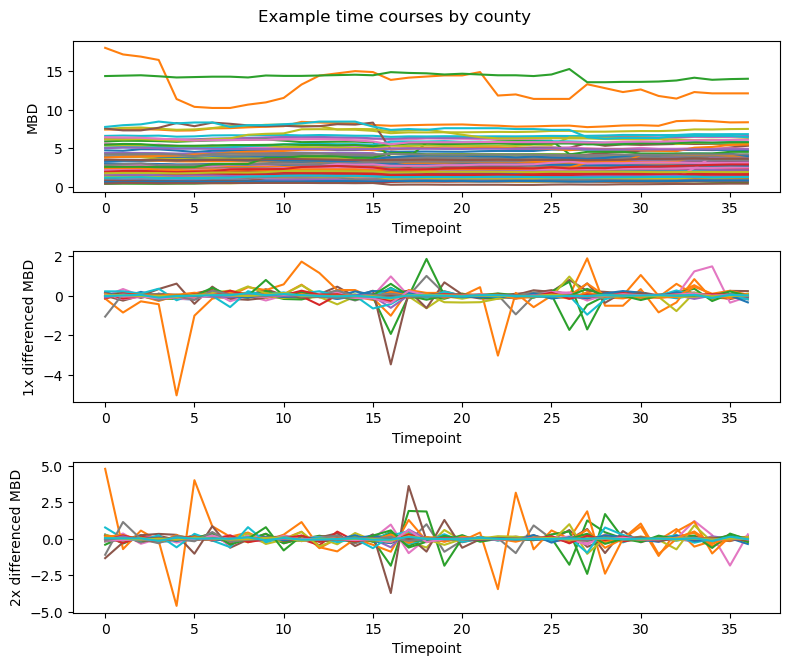

In [2]:
plt = funcs.plot_timeseries(
    data_types = ['microbusiness_density', 'microbusiness_density_change', 'microbusiness_density_change_change'],
    data_type_strings = ['MBD', '1x differenced MBD', '2x differenced MBD'],
    num_counties = num_counties,
    block_size = block_size
)

OK, kind of hard to look at so many counties on top of each other, and hard to draw any conclusions from manually inspecting such a small number of counties. See notebook #02.1 for more in-depth data exploration.

We do know from our unit root testing (see notebook #02.2) that there are many non-stationary counties (and some other weird stuff) This is supported by the plots above. The issues with non-stationarity are mostly alleviated by one differencing, at least according to unit root testing. So, let's plan to start off using 1 for our model's differencing degree.

<a name="autocorrelation_plots"></a>
### 2. Autocorrelation plots

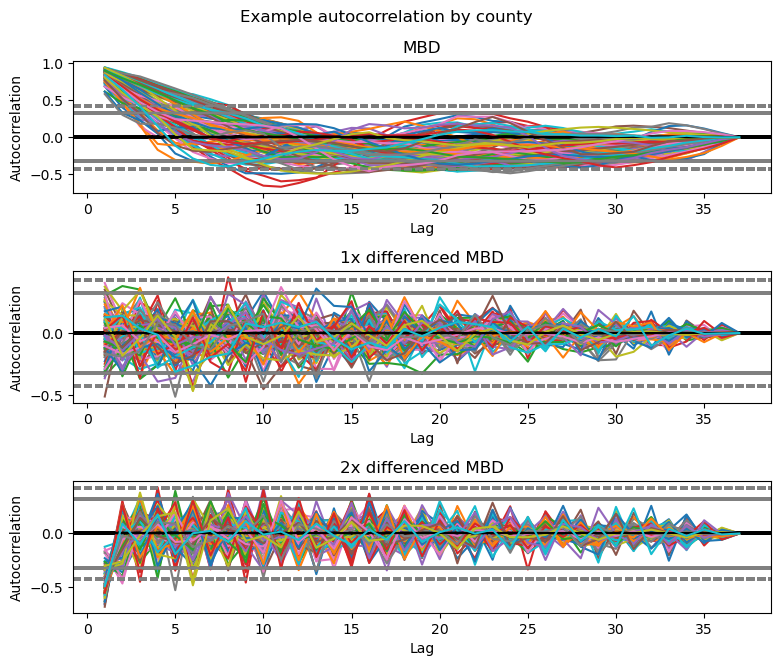

In [3]:
plt = funcs.plot_autocorrelation(
    data_types = ['microbusiness_density', 'microbusiness_density_change', 'microbusiness_density_change_change'],
    data_type_strings = ['MBD', '1x differenced MBD', '2x differenced MBD'],
    num_counties = num_counties,
    block_size = block_size
)

From the autocorrelation plots we can see that raw MBD data tends to have good positive autocorrelation out to about up to about 5-8 lags or so for most of the counties plotted above. After, that it tends to dip negative in most cases. I think we will probably want to start with lag order around 5. After differencing, any consistent autocorrelation signature is pretty much gone. Let's fit an ARIMA model to a these counties with lag order 5 and see what we get. Also, going to try using raw vs 1x vs 2x differenced data for input and/or setting the model difference order to 0 or 1.

<a name="differencing"></a>
### 2. ARIMA: differenced input vs difference order model parameter

In [4]:
fitted_models_df = funcs.ARIMA_optimization(
    data_types = ['microbusiness_density', 'microbusiness_density_change', 'microbusiness_density_change_change'],
    data_type_strings = ['raw MBD', '1x detrended MBD', '2x detrended MBD'],
    lag_orders = [5],
    difference_degrees = [0,1],
    moving_average_orders = [0],
    block_sizes = [block_size],
    num_counties = num_counties,
    suppress_fit_warnings = True
)

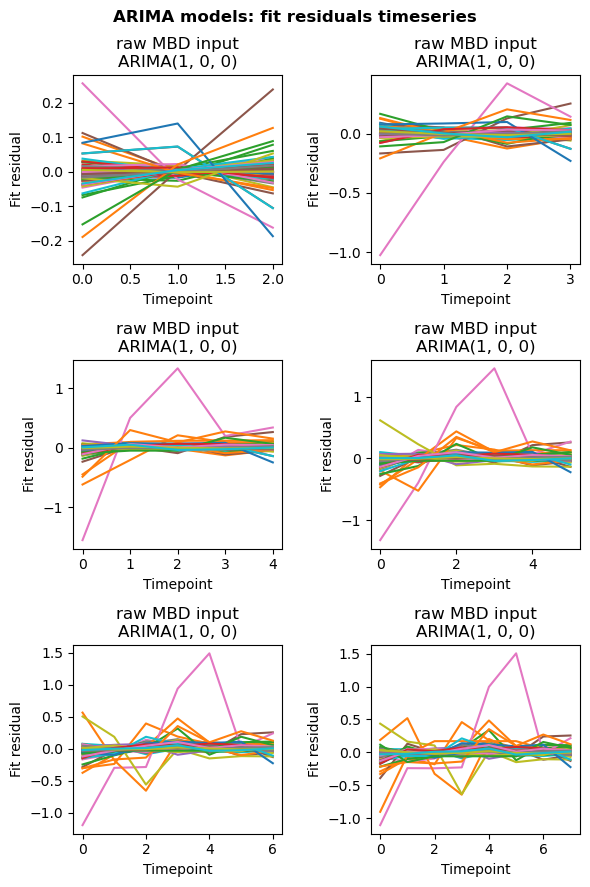

In [21]:
plt = funcs.plot_residuals(
    fitted_models_df = fitted_models_df,
    plot_rows = [0,1,2],
    plot_cols = [0,1],
    title_template = '$data_type_string input\nARIMA($lag_order, $difference_degree, $moving_average_order)',
    plot_dim = 3,     
)

So differencing strategy seems like it makes a difference for some individual counties, but overall there does not seem to be a big effect. Also, it appears to be the counties with the largest MBD values which have the largest fit residuals. Maybe we should standardize the data. While I bet it would make the plots look better, I'm not convinced that will really improve goodness of fit because we are fitting an individual model to each county.

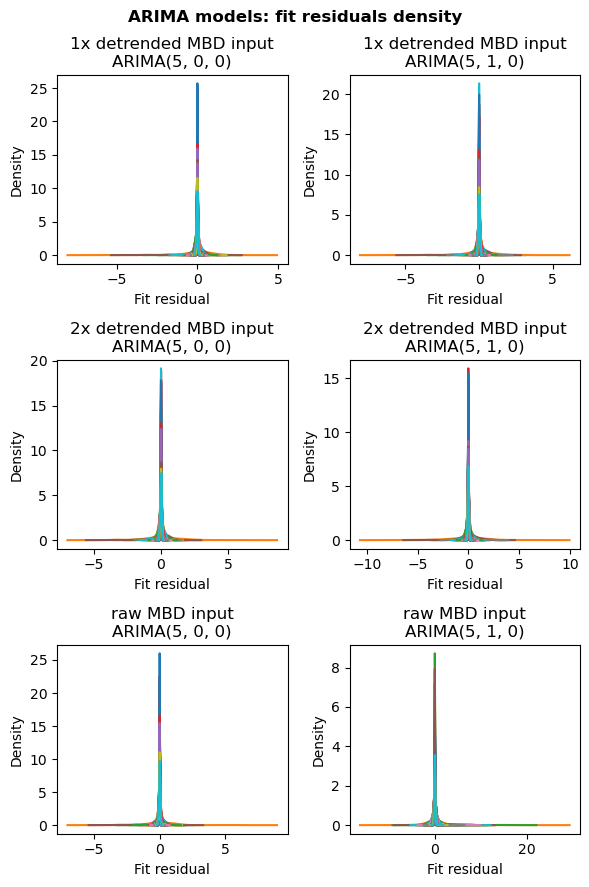

In [6]:
plt = funcs.plot_residuals(
    fitted_models_df = fitted_models_df,
    plot_rows = [0,1,2],
    plot_cols = [0,1],
    title_template = '$data_type_string input\nARIMA($lag_order, $difference_degree, $moving_average_order)',
    plot_dim = 3,
    plot_density = True
)

Not much new here - good news, all the differencing strategies have residuals centered on zero.

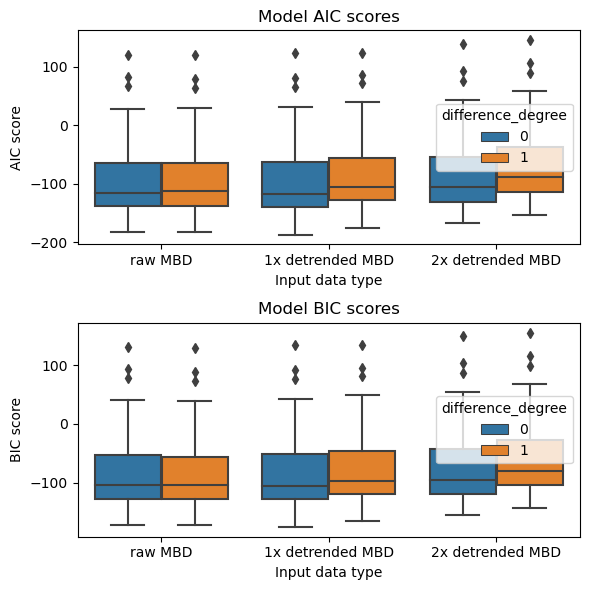

In [7]:
plt = funcs.model_performance_boxplot(
    fitted_models_df = fitted_models_df,
    x_variable = 'data_type_string',
    x_axis_label = 'Input data type',
    hue_by = 'difference_degree',
    fig_width = 6
)

AIC and BIC both tell the same story - differencing strategy is not making a huge impact on goodness of fit. Raw MBD with a model differencing degree of zero looks best, but not by much. Setting the difference degree to 1 is worse over all, especially with input data that has already been detrended by differencing.

One caveat to interpretation here - we are only looking at 'goodness-of-fit', e.g. residual, AIC etc., not actual predictive ability of the model. That will come from the bootstrapping.

Let's keep experimenting. For now, let's assume raw MBD input with a model difference order of zero. Next thing I want to try is the lag order. We assumed a lag order of 5 was Ok to start from the autocorrelation plot, let's test that now.

<a name="lag_order"></a>
### 3. ARIMA: Lag order

In [8]:
fitted_models_df = funcs.ARIMA_optimization(
    data_types = ['microbusiness_density'],
    data_type_strings = ['raw MBD'],
    lag_orders = [0,1,2,3,4,5,6,7,8],
    difference_degrees = [0],
    moving_average_orders = [0],
    block_sizes = [block_size],
    num_counties = num_counties,
    suppress_fit_warnings = True
)

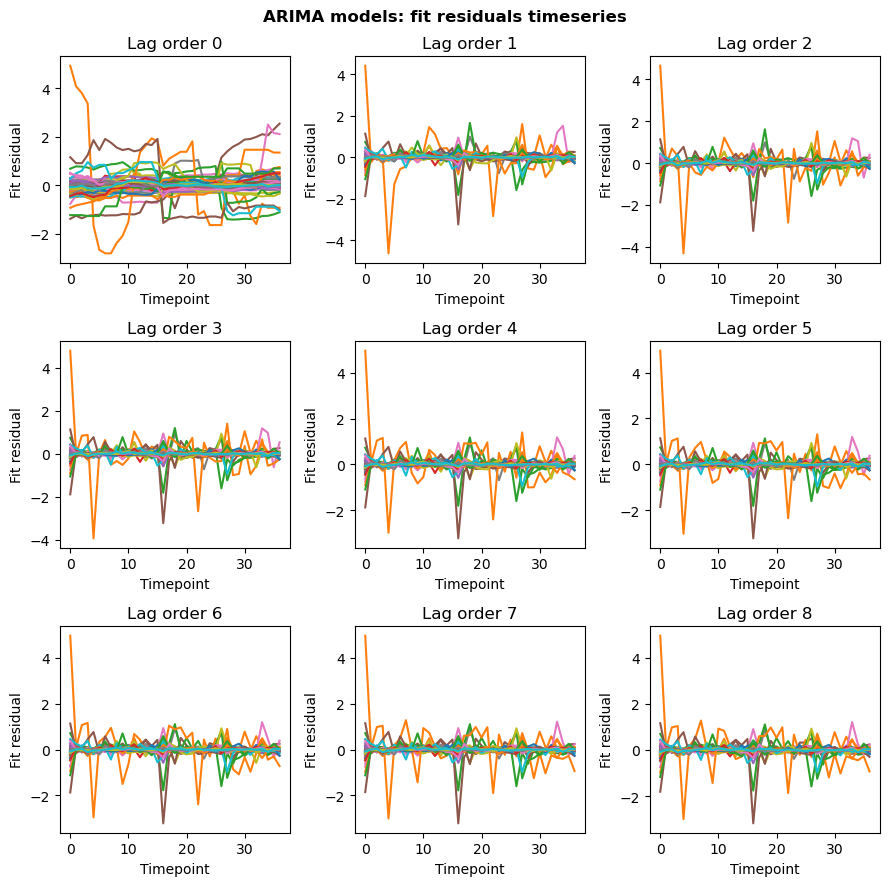

In [9]:
plt = funcs.plot_residuals(
    fitted_models_df = fitted_models_df,
    plot_rows = [0,1,2],
    plot_cols = [0,1,2],
    title_template = 'Lag order $lag_order',
    plot_dim = 3,     
)

Ok, so, lag order 1 looks bad, Lag order > 1 better and pretty much the same. Lower lag orders seem to have a few larger spikes for specific counties, but one is not clearly better than the other.

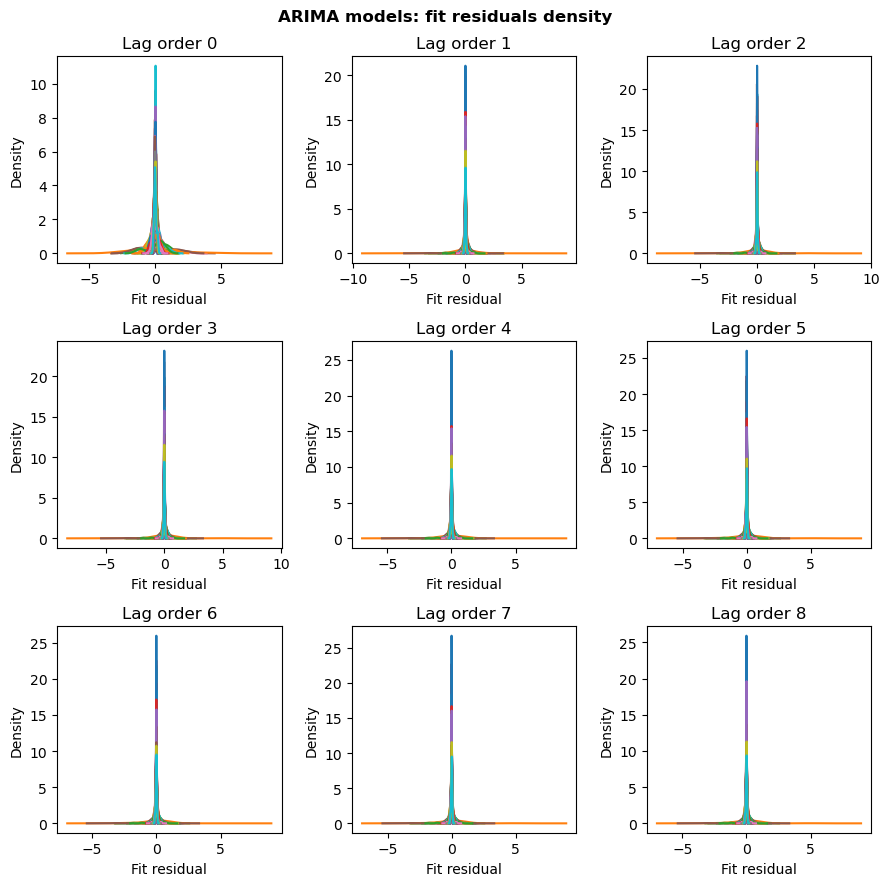

In [10]:
plt = funcs.plot_residuals(
    fitted_models_df = fitted_models_df,
    plot_rows = [0,1,2],
    plot_cols = [0,1,2],
    title_template = 'Lag order $lag_order',
    plot_dim = 3,
    plot_density = True     
)

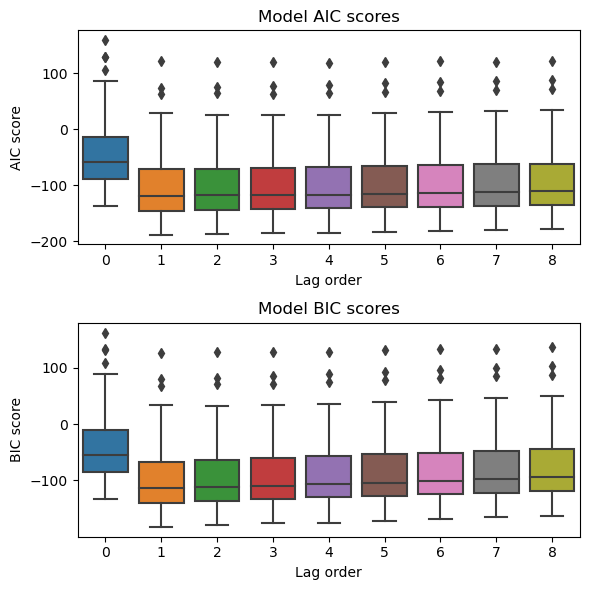

In [11]:
plt = funcs.model_performance_boxplot(
    fitted_models_df = fitted_models_df,
    x_variable = 'lag_order',
    x_axis_label = 'Lag order',
    fig_width = 6
)

Ok, pretty clear - lag order zero = bad, lag order 1 = good, lag order > 1, worse the larger lag order gets. Let's assume lag order of 1 for now.

<a name="moving_average_order"></a>
### 4. ARIMA: moving average order

In [13]:
fitted_models_df = funcs.ARIMA_optimization(
    data_types = ['microbusiness_density'],
    data_type_strings = ['raw MBD'],
    lag_orders = [1],
    difference_degrees = [0],
    moving_average_orders = [0,1,2,3,4,5,6,7,8],
    block_sizes = [block_size],
    num_counties = num_counties,
    suppress_fit_warnings = True
)

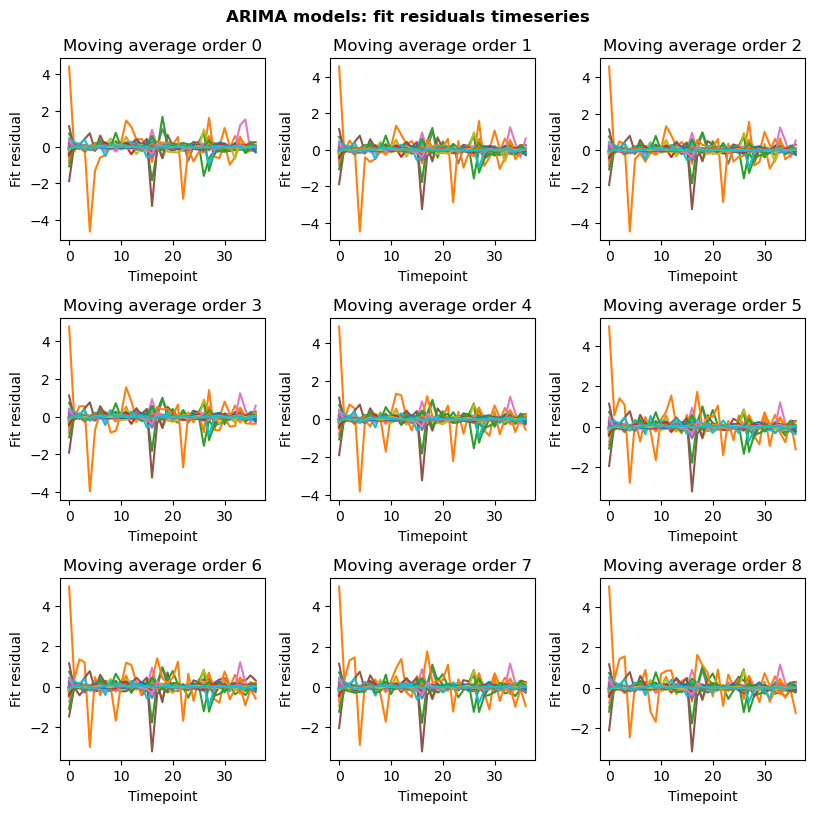

In [14]:
plt = funcs.plot_residuals(
    fitted_models_df = fitted_models_df,
    plot_rows = [0,1,2],
    plot_cols = [0,1,2],
    title_template = 'Moving average order $moving_average_order',
    plot_dim = 2.75,     
)

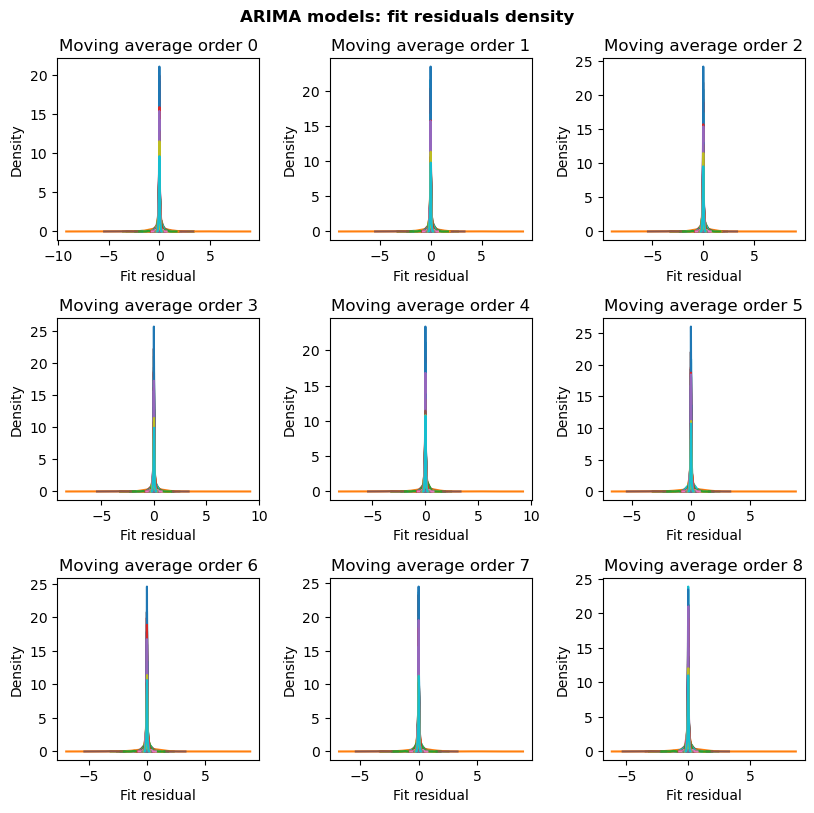

In [15]:
plt = funcs.plot_residuals(
    fitted_models_df = fitted_models_df,
    plot_rows = [0,1,2],
    plot_cols = [0,1,2],
    title_template = 'Moving average order $moving_average_order',
    plot_dim = 2.75,
    plot_density = True
)

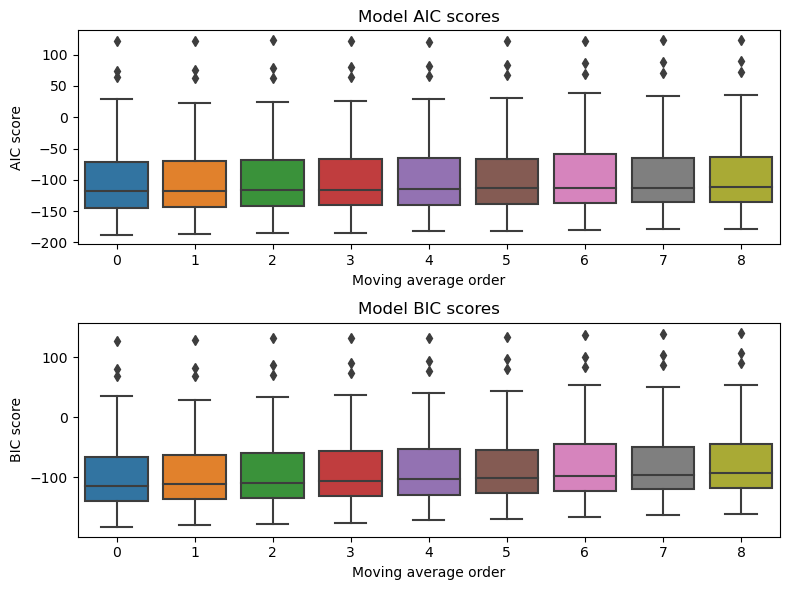

In [16]:
plt = funcs.model_performance_boxplot(
    fitted_models_df = fitted_models_df,
    x_variable = 'moving_average_order',
    x_axis_label = 'Moving average order',
    fig_width = 8
)

Similar-ish results for different moving average orders. Looking at AIC & BIC, zero may be 'best' but results are basically identical.
1. Use raw MBD data with difference order set to 0.
2. Use lag order of 1
3. Choice of moving average order does not appear to make a difference, use 0 for simplicity

This is a small sample and a very subjective way to consume the results, so there could be small differences that will matter with all ~3k counties that are just not obvious here. Also, remember, this is all in sample 'goodness-of-fit'. Not out of sample testing.

<a name="block_size"></a>
### 5. ARIMA: input data block size

In [17]:
fitted_models_df = funcs.ARIMA_optimization(
    data_types = ['microbusiness_density'],
    data_type_strings = ['raw MBD'],
    lag_orders = [1],
    difference_degrees = [0],
    moving_average_orders = [0],
    block_sizes = list(range(3,38)),
    num_counties = num_counties,
    suppress_fit_warnings = True
)

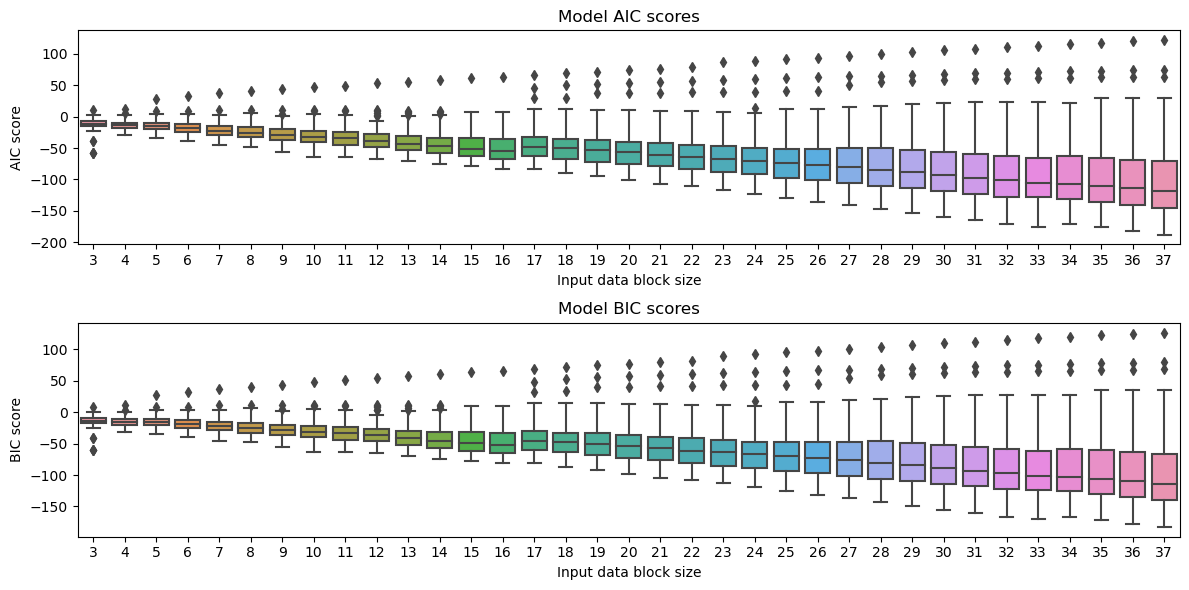

In [18]:
plt = funcs.model_performance_boxplot(
    fitted_models_df = fitted_models_df,
    x_variable = 'block_size',
    x_axis_label = 'Input data block size',
    fig_width = 12
)

Interesting effect here: mean AIC/BIC improves a bit with increasing input block size, but so does the variance. Cool. Also, keep in mind that these are the first block in each time series. All block sizes here have the same left edge and include more and more data forward in time. Maybe let't try using the last block from each timeseries where the right edge is constant and the longer blocks include more past data.

In [19]:
fitted_models_df = funcs.ARIMA_optimization(
    data_types = ['microbusiness_density'],
    data_type_strings = ['raw MBD'],
    lag_orders = [1],
    difference_degrees = [0],
    moving_average_orders = [0],
    block_sizes = list(range(3,38)),
    timepoint_index = -1,
    num_counties = num_counties,
    suppress_fit_warnings = True
)

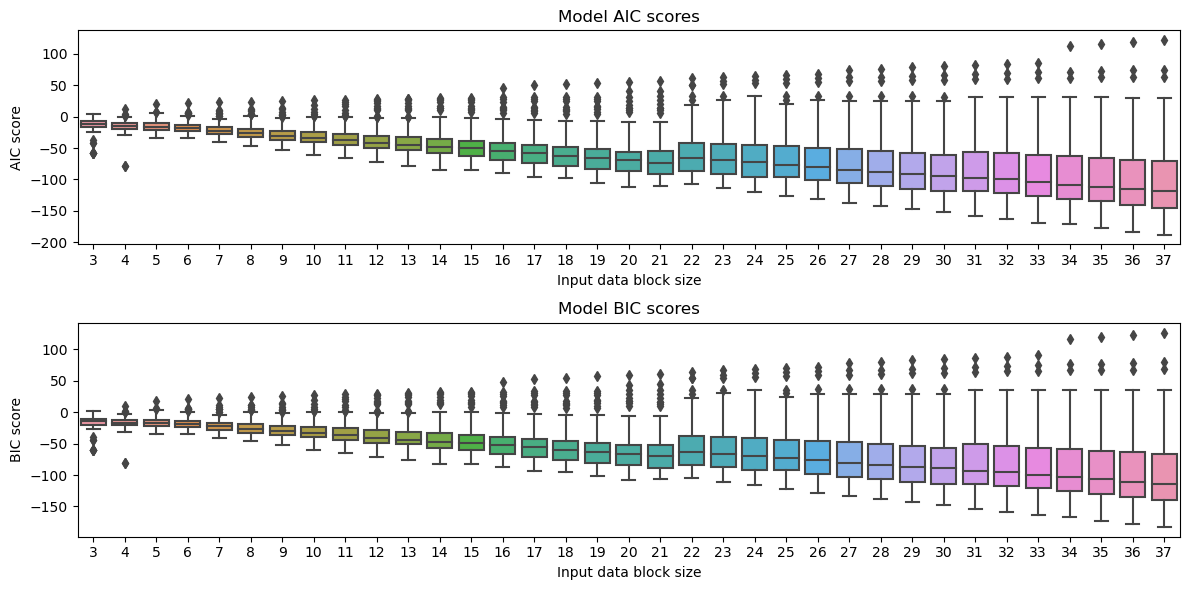

In [20]:
plt = funcs.model_performance_boxplot(
    fitted_models_df = fitted_models_df,
    x_variable = 'block_size',
    x_axis_label = 'Input data block size',
    fig_width = 12
)

Looks pretty similar to the first result. This mean, variance tradeoff is going to be interesting if it is also present in forecast accuracy. It basically says, we can have better models overall at the cost of our worst models being even worse, but also our best models being better.